# Import

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
from IPython.display import clear_output

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('drive/My Drive/DS301')

In [3]:
df = pd.read_csv('recs2015_public_v4.csv')

In [4]:
df.dropna(inplace=True)

In [5]:
df.set_index('DOEID', inplace=True)

In [6]:
df

,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,ZBASEFIN,...,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
DOEID,,,,,,,,,,,,,,,,,,,,,
10001,4,10,METRO,U,2,0,0,0,-2,-2,...,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
10003,3,6,METRO,U,2,0,1,0,1,0,...,0,100.14,1,0,137.45,-2,-2,91.33,-2,-2
10005,1,2,METRO,U,2,0,1,0,0,0,...,0,102.83,1,0,137.45,-2,-2,91.33,-2,-2
10007,3,5,METRO,U,4,0,-2,-2,-2,-2,...,0,102.79,1,0,137.45,-2,-2,91.33,-2,-2
10008,2,3,METRO,R,2,0,1,0,1,0,...,0,101.53,1,0,137.45,-2,-2,91.33,-2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15674,1,2,METRO,U,2,0,1,0,1,0,...,0,98.69,1,0,137.45,-2,-2,91.33,-2,-2
15675,4,8,MICRO,C,2,0,1,0,1,0,...,0,89.69,1,0,137.45,-2,-2,91.33,-2,-2
15679,2,3,METRO,U,2,0,0,0,-2,-2,...,0,100.23,1,0,137.45,-2,-2,91.33,-2,-2


# Data Exploration

In [7]:
cb = pd.read_excel('codebook_publicv4.xlsx', header=3)

In [8]:
cb.columns

Index(['SAS Variable Name', 'Type', 'Length', 'Variable Description',
       'Unnamed: 4', 'Final Response Set', 'Electricity', 'Natural Gas',
       'Propane', 'Fuel Oil/\nKerosene'],
      dtype='object')

In [9]:
cb['Type'].value_counts()

Numeric      754
Character      5
Name: Type, dtype: int64

In [10]:
cb[cb['Type'] == 'Character']['SAS Variable Name'].values

array(['DOEID', 'METROMICRO', 'UATYP10', 'CLIMATE_REGION_PUB',
       'IECC_CLIMATE_PUB'], dtype=object)

In [11]:
df['IECC_CLIMATE_PUB'].value_counts()

5A               877
3B-4B            570
4A               540
3A               291
1A-2A            257
5B-5C            231
6A-6B            217
3C               183
4C                56
2B                47
7A-7B-7AK-8AK     35
Name: IECC_CLIMATE_PUB, dtype: int64

# Identify Categoricals

In [12]:
categoricals = []
categoricals += cb[cb['Type'] == 'Character']['SAS Variable Name'].tolist()
categoricals += ['REGIONC', 'DIVISION', 'TYPEHUQ', 'STORIES', 'KOWNRENT', 'WALLTYPE', 'ROOFTYPE', 'TYPEGLASS', 'WINFRAME', 'FUELPOOL', 'FUELTUB', 'LOCRFRI2', 'UPRTFRZR', 'STOVENFUEL', 'DUALCOOKTFUEL', 'DUALOVENFUEL', 'STOVEFUEL', 'OVENFUEL', 'OUTGRILLFUEL', 'DWCYCLE', 'TOPFRONT', 'DRYRFUEL', 'TVTYPE1', 'TVTYPE2', 'DNTHEAT', 'EQUIPM', 'FUELHEAT', 'EQUIPMUSE', 'EQUIPAUXTYPE', 'FUELAUX', 'COOLTYPE', 'USECENAC', 'USEWWAC', 'FUELH2O', 'H2OHEATAPT', 'FUELH2O2', 'AUDIT', 'AUDITCHG', 'ELPAY', 'NGPAY', 'LPGPAY', 'FOPAY', 'HHSEX', 'EMPLOYHH', 'SDESCENT', 'HOUSEHOLDER_RACE']
categoricals.remove('DOEID')
len(categoricals)

50

# Select Features

In [13]:
X = df.loc[:, :'DBT99']
X = X.drop(columns=[column for column in X.columns if column.startswith('BRRWT')], inplace=False)

In [14]:
y = df['TOTALBTU']
# Alternative target variable with log10 scaling
# y = df['TOTALBTU'].apply(math.log10)

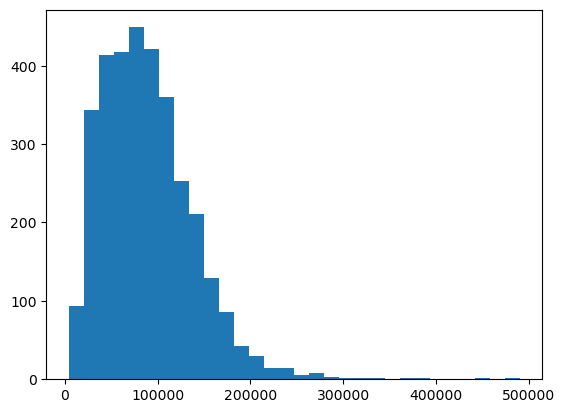

In [15]:
plt.hist(y, bins=30)
plt.show()

# Custom Function

In [16]:
def evaluate(regressor, metrics, metric_frame, X, y, regressor_name=None, feature_importance=True, regressor_params={}, param_grid={}):
    
    name = regressor_name if regressor_name else regressor.__name__
    
    # Use GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(regressor(**regressor_params), param_grid, n_jobs=-1)
    grid.fit(X, y)
    if grid.best_params_:
        print(grid.best_params_)
    
    # Split training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model on all features
    reg = regressor(**regressor_params, **grid.best_params_)
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    
    # Calculate RMSE
    rmse_train = math.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
    rmse_test = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))
    
    # Create subplots to show scatterplot for both training and testing
    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
    
    # Scatterplot for training
    axs[0].scatter(x=y_pred_train, y=y_train, s=1)
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')
    axs[0].set_title(f'{name} - Train - RMSE: {rmse_train}')
    
    # Scatterplot for testing
    axs[1].scatter(x=y_pred_test, y=y_test, s=1)
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')
    axs[1].set_title(f'{name} - Test - RMSE: {rmse_test}')
    
    # Save the plots
    plt.savefig(f'{name}.png')
    plt.show()
        
    # Calculate baseline metrics
    for metric in metrics:
        metric_frame.at[name, metric.__name__] = metric(y_true=y_test, y_pred=y_pred_test)

    if feature_importance:
        # Use permutation_importance to evaluate feature importance 
        permutation_metrics = {metric.__name__:make_scorer(metric) for metric in metrics}
        r_multi = permutation_importance(reg, X_test, y_test, n_repeats=30, random_state=0, scoring=permutation_metrics)
        for metric in r_multi:
            print(f"{metric}")
            r = r_multi[metric]
            # Limit to printing 5 most important features
            for i in r.importances_mean.argsort()[::-1][:5]:
                # if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
                    print(f"    {X_test.columns[i]:<25}"
                          f"{r.importances_mean[i]:.3f}"
                          f" +/- {r.importances_std[i]:.3f}")

# Metrics

In [17]:
# metrics must accept parameters y_true and y_pred
metrics = [mean_squared_error, mean_absolute_error, r2_score]
# make a DataFrame to store the baseline metrics
metric_frame = pd.DataFrame(dtype='float64')

# Cleaning Methods

In [18]:
# Drop imputation flags
flags = [column for column in X.columns if column.startswith('Z')]
X.drop(columns=flags, inplace=True)

In [19]:
# Transform categoricals into indicators
# categoricals = cb[cb['Type'] == 'Character']['SAS Variable Name'].tolist()[1:]
dummies = pd.get_dummies(data=df[categoricals].astype(str))
X = X.drop(columns=categoricals, inplace=False)
X = pd.concat([X, dummies], axis = 1)

In [20]:
# Drop "Final Sample Weight"
X = X.drop(columns=['NWEIGHT'], inplace=False)

In [21]:
# Replace not applicable, refused, or don't know with reasonable values
X.replace({-2:0, -8:0.5, -9:0.5}, inplace=True)

In [22]:
X.columns

Index(['CELLAR', 'BASEFIN', 'ATTIC', 'ATTICFIN', 'PRKGPLC1', 'SIZEOFGARAGE',
       'YEARMADERANGE', 'OCCUPYYRANGE', 'STUDIO', 'BEDROOMS',
       ...
       'EMPLOYHH_1', 'EMPLOYHH_2', 'SDESCENT_0', 'SDESCENT_1',
       'HOUSEHOLDER_RACE_1', 'HOUSEHOLDER_RACE_2', 'HOUSEHOLDER_RACE_3',
       'HOUSEHOLDER_RACE_4', 'HOUSEHOLDER_RACE_5', 'HOUSEHOLDER_RACE_7'],
      dtype='object', length=477)

# Linear Regression

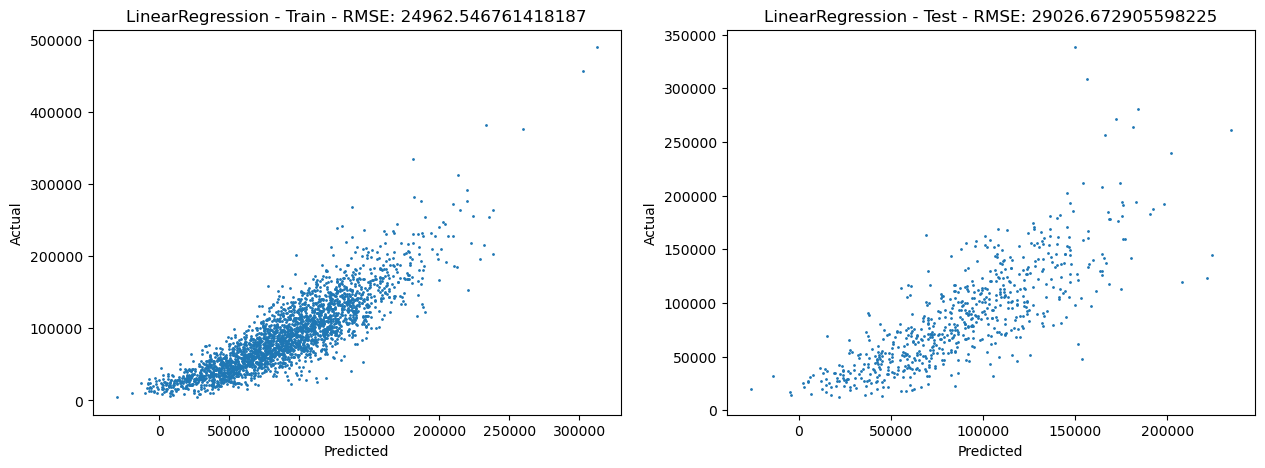

mean_squared_error
    FUELH2O_8                12179340.393 +/- 5182463.494
    SOLWATER                 6772505.305 +/- 3274483.522
    AGERFRI1                 6526805.543 +/- 2722519.235
    EQUIPAGE                 5674915.224 +/- 2484118.022
    SWAMPCOL                 4003291.226 +/- 2247840.956
mean_absolute_error
    EQUIPAGE                 70.412 +/- 40.326
    VCR                      59.817 +/- 49.323
    WINFRAME_1               53.548 +/- 83.008
    FUELH2O_8                52.001 +/- 48.786
    NOACDAYS                 50.865 +/- 27.330
r2_score
    TOTSQFT_EN               3.659 +/- 0.142
    TOTCSQFT                 1.081 +/- 0.061
    TOTHSQFT                 1.061 +/- 0.056
    HDD65                    0.487 +/- 0.027
    TOTUCSQFT                0.462 +/- 0.030


In [23]:
evaluate(LinearRegression, metrics, metric_frame, X, y, None, True, 
         {})

# XGBoost

In [24]:
param_grid_xgb = {
    'n_estimators':[10, 100, 1000],
    'max_depth':[1, 10, 100, None]
}

{'max_depth': 1, 'n_estimators': 1000}


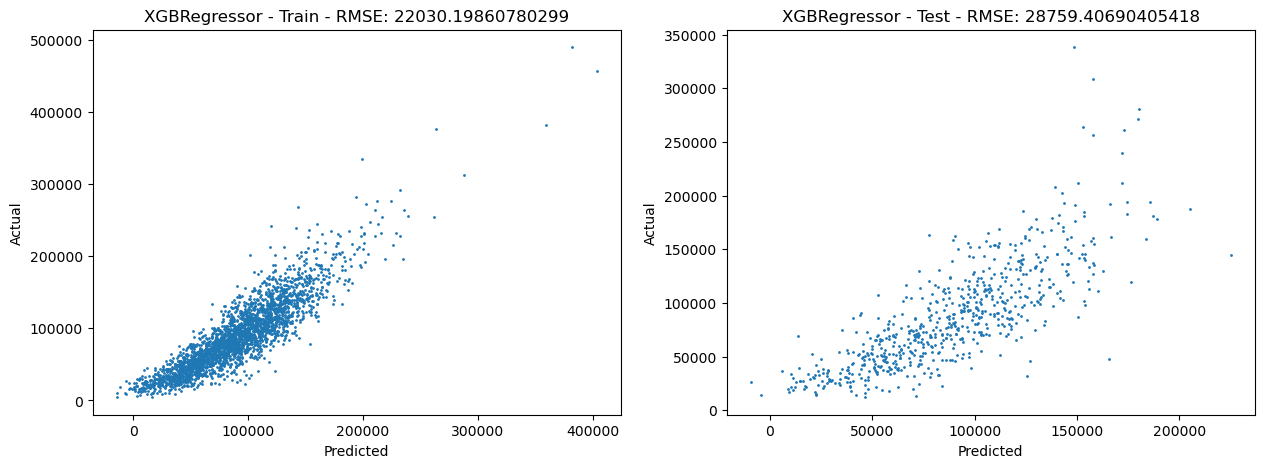

mean_squared_error
    BEDROOMS                 8071639.598 +/- 3801110.427
    COOKTUSE                 6708159.825 +/- 4066735.743
    NUMTABLET                4579983.562 +/- 3836213.193
    TEMPGONEAC               2430002.199 +/- 2718273.614
    SWAMPCOL                 1992318.879 +/- 1241507.190
mean_absolute_error
    WINFRAME_1               58.623 +/- 49.335
    AMTMICRO                 58.281 +/- 31.908
    BEDROOMS                 56.253 +/- 57.784
    NUMMEAL                  52.774 +/- 39.670
    COOKTUSE                 47.597 +/- 46.060
r2_score
    WINDOWS                  0.050 +/- 0.008
    TOTSQFT_EN               0.037 +/- 0.006
    HDD50                    0.026 +/- 0.005
    CELLAR                   0.016 +/- 0.004
    DIVISION_10              0.014 +/- 0.003


In [25]:
evaluate(XGBRegressor, metrics, metric_frame, X, y, None, True, 
         {'objective':'reg:squarederror', 'random_state':0}, param_grid_xgb)

# Linear SVR

C:\Users\Brendabadbad\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Brendabadbad\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


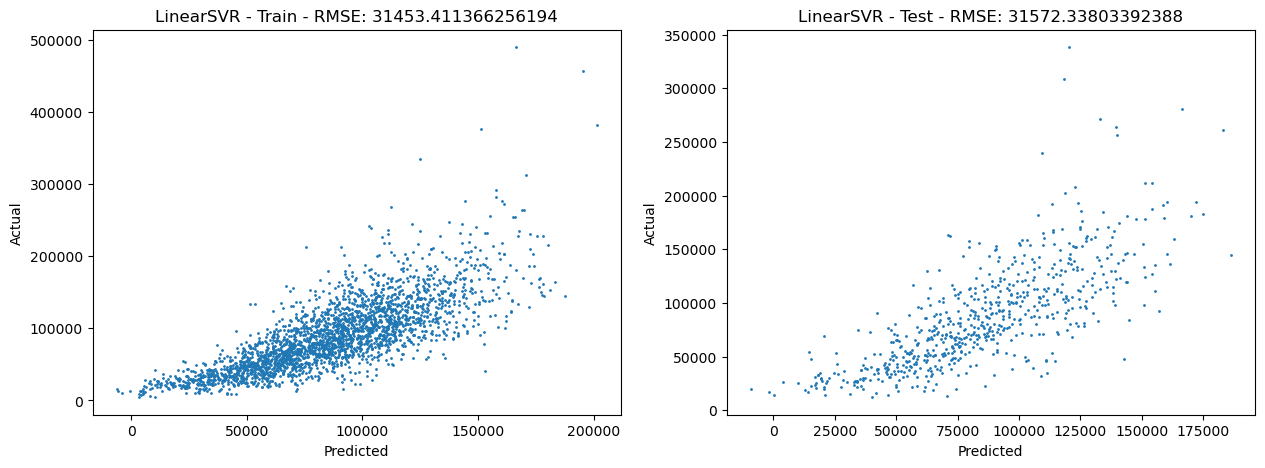

mean_squared_error
    AGERFRI1                 3822515.851 +/- 1910101.816
    WWACAGE                  1150496.391 +/- 1129389.294
    TOTUSQFT                 881730.003 +/- 1780694.727
    AMTMICRO                 761337.287 +/- 2061986.856
    WHEATAGE                 727957.790 +/- 877769.244
mean_absolute_error
    AGERFRI1                 66.756 +/- 33.969
    AMTMICRO                 33.418 +/- 41.734
    TOTUSQFT                 26.966 +/- 29.290
    TEMPGONE                 23.643 +/- 71.832
    NOHEATDAYS               18.232 +/- 11.202
r2_score
    HDD65                    0.912 +/- 0.046
    HDD30YR                  0.252 +/- 0.016
    TOTSQFT_EN               0.084 +/- 0.010
    WINDOWS                  0.056 +/- 0.010
    CDD65                    0.054 +/- 0.006


In [26]:
evaluate(LinearSVR, metrics, metric_frame, X, y, None, True, 
         {'dual':True, 'random_state':0, 'max_iter':10000})

# RF

In [27]:
param_grid_rf = {
    'n_estimators':[10, 100, 1000],
    'max_depth':[1, 10, 100, None]
}

{'max_depth': 100, 'n_estimators': 1000}


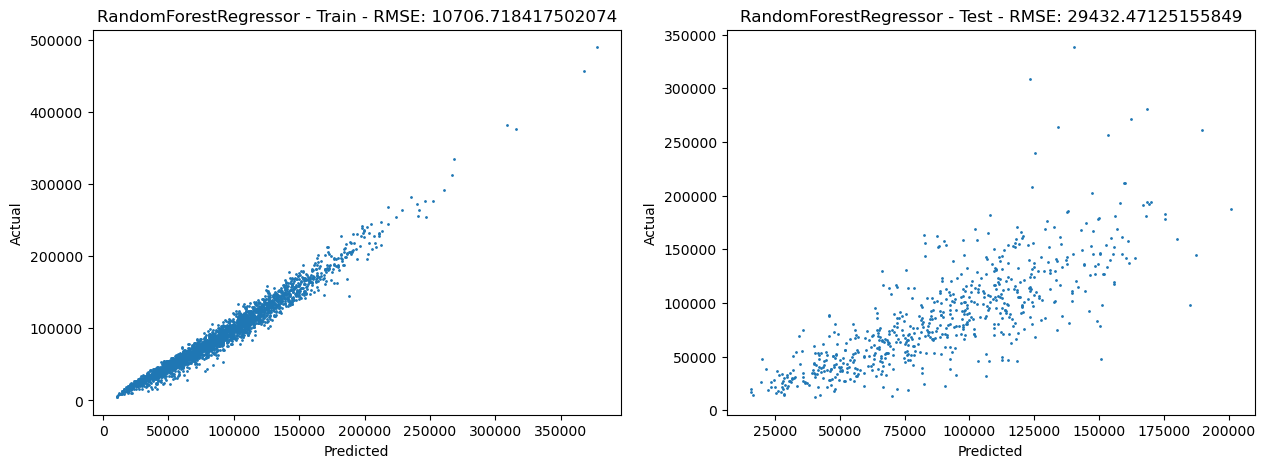

mean_squared_error
    LGTINCAN                 744041.279 +/- 442201.109
    SCALEG                   649548.052 +/- 276652.231
    AGECDRYER                636866.686 +/- 369674.661
    DIVISION_3               585510.613 +/- 1346765.069
    METROMICRO_MICRO         475906.075 +/- 141160.968
mean_absolute_error
    NCOMBATH                 29.262 +/- 19.158
    NHAFBATH                 21.663 +/- 18.404
    DIVISION_7               21.537 +/- 9.397
    CDD80                    20.427 +/- 25.612
    CDD30YR                  16.127 +/- 24.594
r2_score
    TOTSQFT_EN               0.160 +/- 0.017
    WINDOWS                  0.040 +/- 0.009
    HDD50                    0.040 +/- 0.007
    DBT99                    0.031 +/- 0.005
    DIVISION_10              0.008 +/- 0.005


In [28]:
evaluate(RandomForestRegressor, metrics, metric_frame, X, y, None, True, 
         {'criterion':'squared_error', 'n_jobs':-1, 'random_state':0}, param_grid_rf)

# AdaBoost

In [29]:
param_grid_adb = {
    'estimator':[
        DecisionTreeRegressor(max_depth=1),
        DecisionTreeRegressor(max_depth=10),
        DecisionTreeRegressor(max_depth=None)
    ],
    'n_estimators':[10, 50, 100],
    'learning_rate':[0.1, 1.0, 10]
}

{'estimator': DecisionTreeRegressor(max_depth=10), 'learning_rate': 1.0, 'n_estimators': 100}


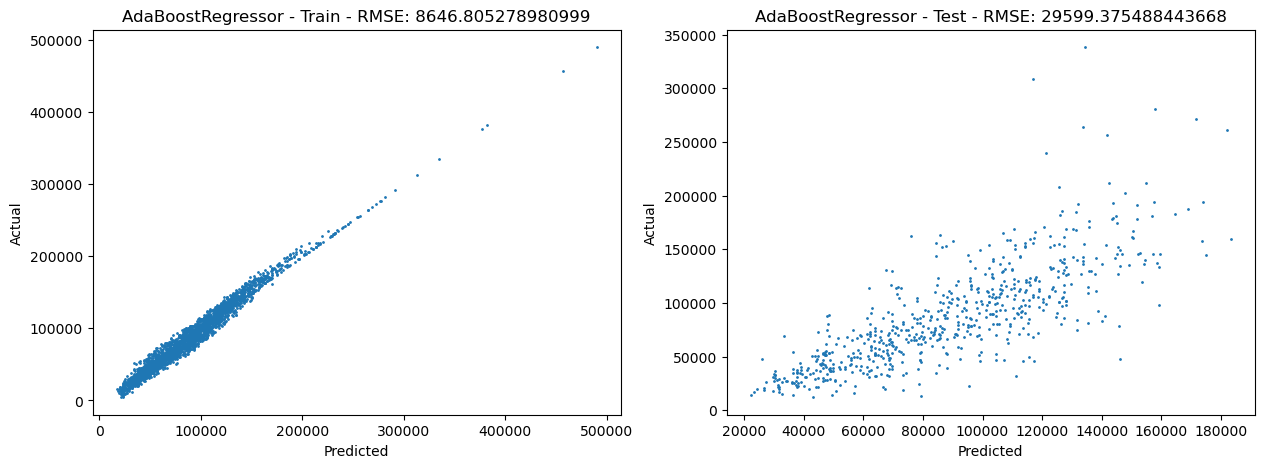

mean_squared_error
    AGECDRYER                3258596.145 +/- 1366641.241
    CDD65                    2947400.103 +/- 1478578.334
    HHAGE                    2616854.179 +/- 1894217.048
    LGTINCAN                 2431946.251 +/- 1077434.482
    TOTCSQFT                 1970740.193 +/- 2141192.784
mean_absolute_error
    CDD65                    72.984 +/- 22.610
    LGTINCAN                 40.225 +/- 15.232
    MONEYPY                  38.248 +/- 69.243
    AGEDW                    32.748 +/- 13.551
    USECENAC_1               26.519 +/- 12.642
r2_score
    TOTSQFT_EN               0.079 +/- 0.011
    WINDOWS                  0.060 +/- 0.009
    HDD50                    0.030 +/- 0.005
    DBT99                    0.016 +/- 0.003
    TOTHSQFT                 0.009 +/- 0.002


In [30]:
evaluate(AdaBoostRegressor, metrics, metric_frame, X, y, None, True, 
         {'random_state':0}, param_grid_adb)

# SVR

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


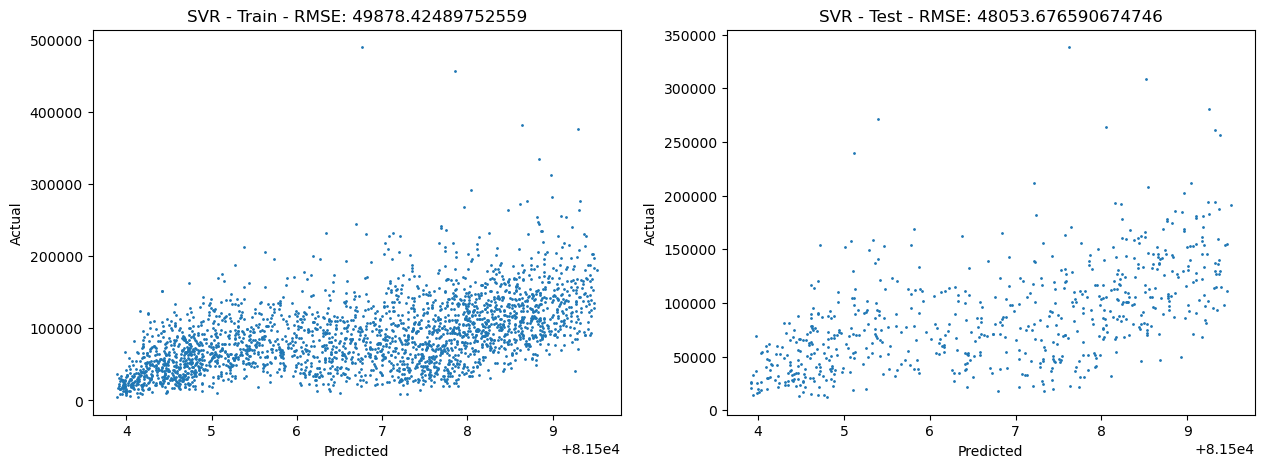

In [31]:
evaluate(BaggingRegressor, metrics, metric_frame, X, y, 'SVR', False, 
         {'estimator':SVR(), 'n_estimators':100, 'bootstrap':True, 'max_samples':0.01, 'n_jobs':-1, 'verbose':True})

# K Neighbors

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


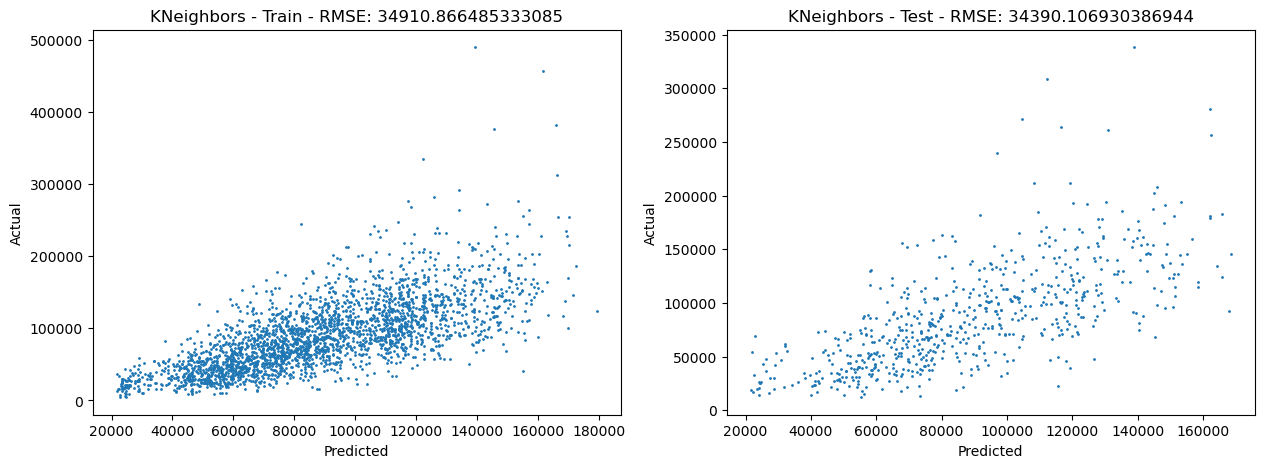

In [32]:
evaluate(BaggingRegressor, metrics, metric_frame, X, y, 'KNeighbors', False, 
         {'estimator':KNeighborsRegressor(), 'n_estimators':10, 'bootstrap':True, 'max_samples':0.1, 'n_jobs':1, 'verbose':True})

# Neural Network

## NN - Define Networks

In [33]:
class MLPClassifier_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D, H)
        self.fc2 = nn.Linear(H, C)
    
    def forward(self, x):
        x = activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [34]:
class MLPClassifier_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, C)
    
    def forward(self, x):
        x = activation(self.fc1(x))
        x = activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [35]:
class MLPClassifier_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, C)
    
    def forward(self, x):
        x = activation(self.fc1(x))
        x = activation(self.fc2(x))
        x = activation(self.fc3(x))
        x = self.fc4(x)
        return x

## NN - Regression Preparation

In [36]:
# Get our device in a variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda:0


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
y_train_tensor = torch.from_numpy(y_train.values).float().to(device)
X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
y_test_tensor = torch.from_numpy(y_test.values).float().to(device)

In [38]:
def train_reg(model, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.L1Loss()
    model.to(device)
    criterion.to(device)
    for epoch in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            # Get the inputs and labels for the current batch
            X_train, y_train = data
            
            # Move inputs and labels to the device
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass over the model to get the logits 
            y_pred = model(X_train)

            # Compute loss
            loss = criterion(y_pred[:, 0], y_train)

            # reset (zero) the gradients before running the backward pass over the model
            # we need to do this because the gradients get accumulated at the same place across iterations
            optimizer.zero_grad()

            # Backward pass to compute the gradient of loss w.r.t our learnable params (weights and biases)
            loss.backward()

            # Update params
            optimizer.step()
            
            # Update running loss
            running_loss += loss.item()
            
            # Print loss every 1000 mini-batches
            if i % 100 == 99:
                clear_output(wait=True)
                print(model)
                print(activation)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
            
        # Print progress
        # clear_output(wait=True)
        # print(f'Epoch: {epoch}')

In [39]:
def evaluate_mae(model, X_test, y_test):
    criterion = nn.L1Loss()
    with torch.no_grad():
        y_pred = model(X_test)
        # print(y_pred)
        mae = criterion(y_pred[:, 0], y_test)
        # print(mae.item())
        return mae.item()

In [40]:
def evaluate_rmse(model, X_test, y_test):
    criterion = nn.MSELoss()
    with torch.no_grad():
        y_pred = model(X_test)
        mse = criterion(y_pred[:, 0], y_test)
        return math.sqrt(mse)

## NN - Hyperparameter Settings

In [41]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

In [42]:
# First lets setup the hyperparameters for our network architecture
seed = 0
random.seed(seed)
torch.manual_seed(seed)
D = X_train.columns.size  # dimensions
C = 1  # num_classes
H = 1000  # num_hidden_units

In [43]:
activations = [nn.Sigmoid(), nn.ReLU(), nn.Tanh(), nn.ELU(), nn.Identity()]
a_names = ['Sigmoid', 'ReLU', 'Tanh', 'ELU', 'None']
models = [MLPClassifier_1, MLPClassifier_2, MLPClassifier_3]
m_names = ['1 layer', '2 layers', '3 layers']
metric_frame_nn = pd.DataFrame(data=0, dtype='float64', index=m_names, columns=a_names)
epoch = 10
learning_rates = [1e-3, 1e-5, 1e-3, 1e-5, 1e-5]
lambda_l2 = 1e-2 # coefficient for the L2 regularizer. You should play with its value to see the effect of regularization
passes = 1

## NN - Run

In [44]:
for i in range(passes):
    for m, m_name in zip(models, m_names):
        for a, a_name, learning_rate in zip(activations, a_names, learning_rates):
            activation = a
            model = m()
            lr = learning_rate
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=lambda_l2) # built-in L2
            train_reg(model, train_loader, optimizer, epoch)
            metric_frame_nn.at[m_name, a_name] += evaluate_rmse(model, X_test_tensor, y_test_tensor)
            print(f'Done {m_name}, {a_name}')
metric_frame_nn = metric_frame_nn.div(passes)

MLPClassifier_3(
  (fc1): Linear(in_features=477, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1, bias=True)
)
Identity()
[10,  2600] loss: 59700.840
Done 3 layers, None


# Dimension Reduction

### PCA with 100 PCs

In [45]:
pca = PCA(n_components=100)
X_pca = pd.DataFrame(pca.fit_transform(X))

{'max_depth': 1, 'n_estimators': 1000}


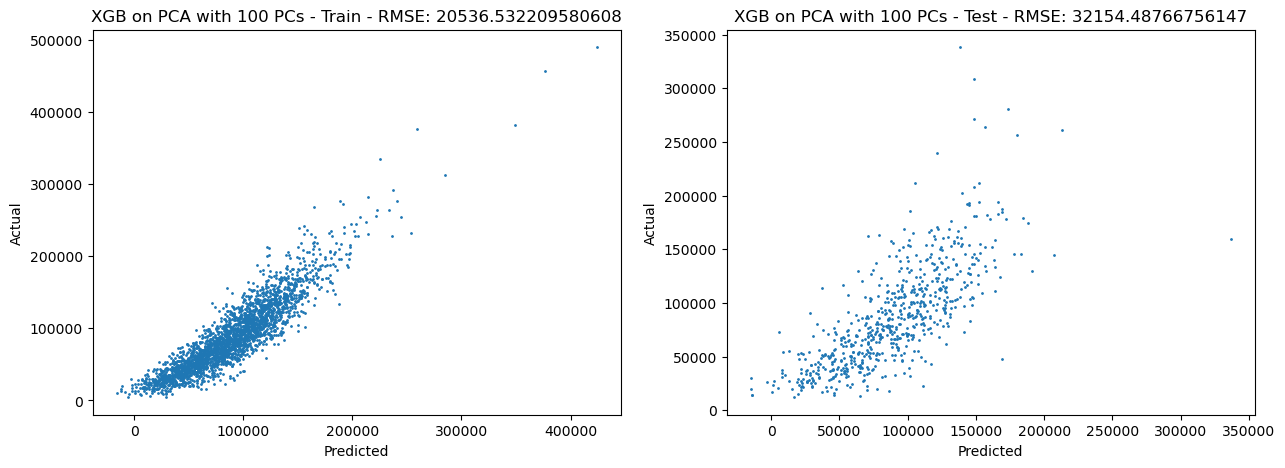

In [46]:
evaluate(XGBRegressor, metrics, metric_frame, X_pca, y, 'XGB on PCA with 100 PCs', False, 
         {'objective':'reg:squarederror', 'random_state':0}, param_grid_xgb)

### PCA with 10 PCs

In [47]:
pca = PCA(n_components=10)
X_pca = pd.DataFrame(pca.fit_transform(X))

{'max_depth': 1, 'n_estimators': 100}


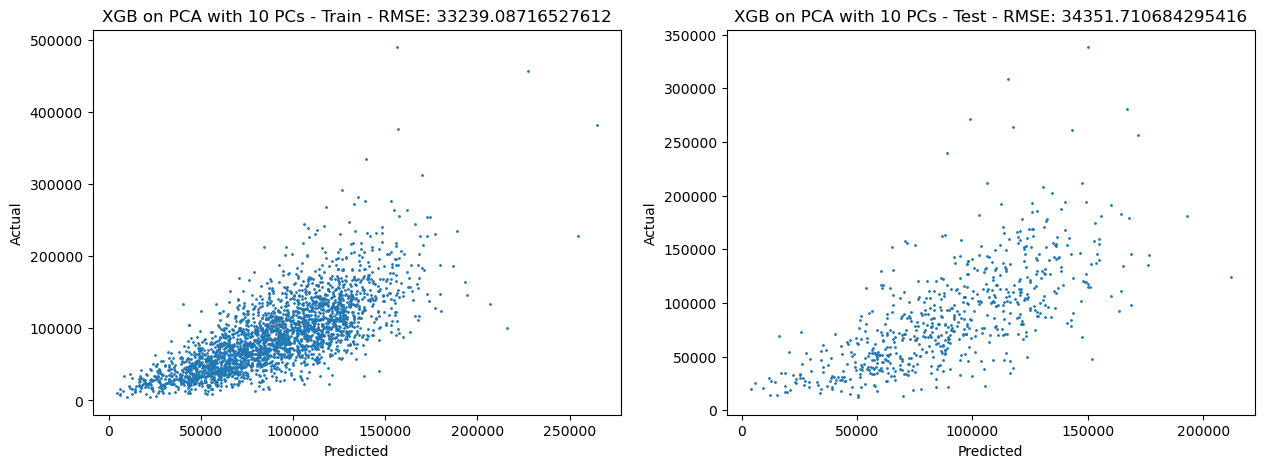

In [48]:
evaluate(XGBRegressor, metrics, metric_frame, X_pca, y, 'XGB on PCA with 10 PCs', False, 
         {'objective':'reg:squarederror', 'random_state':0}, param_grid_xgb)

### First 2 PCs

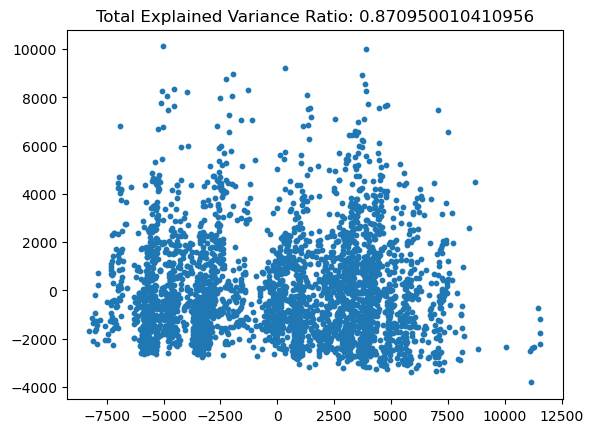

In [49]:
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(X))
plt.scatter(pca_df.loc[:, 0], pca_df.loc[:, 1], s=10)
plt.title(f'Total Explained Variance Ratio: {pca.explained_variance_ratio_.sum()}')
plt.savefig('first_2_pcs.png')
plt.show()

### t-SNE

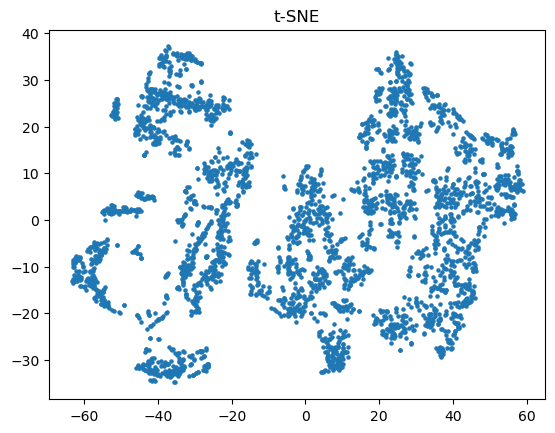

In [50]:
tsne = TSNE(n_components=2, perplexity=50, random_state=0)
tsne_df = pd.DataFrame(tsne.fit_transform(X))
plt.scatter(tsne_df.loc[:, 0], tsne_df.loc[:, 1], s=5)
plt.title('t-SNE')
plt.savefig('t-SNE.png')
plt.show()

# Metrics for Conventional Models

In [51]:
metric_frame['root_mean_squared_error'] = np.sqrt(metric_frame['mean_squared_error'])
metric_frame.sort_values(by='mean_squared_error')

,mean_squared_error,mean_absolute_error,r2_score,root_mean_squared_error
XGBRegressor,8.271035e+08,21063.030907,0.636505,28759.406904
LinearRegression,8.425477e+08,21363.959658,0.629718,29026.672906
RandomForestRegressor,8.662704e+08,20486.357395,0.619292,29432.471252
AdaBoostRegressor,8.761230e+08,20657.918009,0.614962,29599.375488
LinearSVR,9.968125e+08,22486.257972,0.561921,31572.338034
XGB on PCA with 100 PCs,1.033911e+09,23433.490574,0.545617,32154.487668
XGB on PCA with 10 PCs,1.180040e+09,25133.114093,0.481397,34351.710684
KNeighbors,1.182679e+09,25216.297451,0.480237,34390.106930
SVR,2.309156e+09,37074.080359,-0.014826,48053.676591


# Metrics for Neural Networks

In [52]:
metric_frame_nn

,Sigmoid,ReLU,Tanh,ELU,None
1 layer,83383.115413,40660.325626,80350.996410,44760.299552,38296.126175
2 layers,80409.129830,57265.712185,80357.498816,55351.398176,59556.511382
3 layers,80401.058699,99501.266404,80361.496850,99328.036082,36383.064192
